In [ ]:
import javabridge
import bioformats
import numpy as np
import matplotlib.pyplot as plt
from xml.dom.minidom import parse
import xml.dom.minidom
import win32clipboard as clipboard
from tkinter import filedialog
import cv2
import pandas as pd
import tkinter as tk
import tkinter.filedialog as fd
import os
import tifffile as tf
from PIL import Image
import plotly.express as px
import matplotlib.patches as patches

In [ ]:
def wavelength_to_rgb(wavelength, gamma):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    # R *= 255
    # G *= 255
    # B *= 255
    RGB = np.array([R,G,B])
    return RGB

def realtime_lambda_to_graph(x_coordinate, y_coordinate, Image_array, Channel_array, Save_or_not):

    #From single point to square with some side
    #For napari

    side = 10

    x_1 = x_coordinate - side
    x_2 = x_coordinate + side
    y_1 = y_coordinate - side
    y_2 = y_coordinate + side


    Type_conversion_constant = 10000

    Intensity_data = Image_array[x_1:x_2,y_1:y_2,:]

    Intensity_data_avereged = np.average(Intensity_data, axis = (0,1))*Type_conversion_constant


    Channel_array = np.array(Channel_array).astype(int)
    Intensity_data_avereged = Intensity_data_avereged.astype(int)
    

    Spectral_data = np.column_stack((Channel_array, Intensity_data_avereged))

    graphplot = plt.plot(Channel_array,Intensity_data_avereged)
    plt.pause(0.05) #If i want update the graph. But work strange yet
    plt.draw()
    


    if Save_or_not == 1:
        np.savetxt("Spectrum_point.csv", Spectral_data, fmt='%i', delimiter=",")
    else: 
        pass

def toClipboardForExcel(array):
    """
    Copies an array into a string format acceptable by Excel.
    Columns separated by /t, rows separated by /n
    """
    # Borrowed from https://stackoverflow.com/a/22488567. Works only in Windows.
    # Create string from array. 
    line_strings = []
    for line in array:
        line_strings.append("/t".join(line.astype(str)).replace("/n",""))
    array_string = "/r/n".join(line_strings)

    # Put string into clipboard (open, clear, set, close)
    clipboard.OpenClipboard()
    clipboard.EmptyClipboard()
    clipboard.SetClipboardText(array_string)
    clipboard.CloseClipboard()

def channels_to_lambda(image, channel_array):
    z,x,y = np.shape(image)
    single_image_size = [x,y]
    colored_image_array = np.zeros((z,x,y,3)).astype(int)


    for index, wavelength in enumerate(channel_array):
        
    
        rgb_value_channel = wavelength_to_rgb(wavelength,1) #Calculating color for this wavelength (wl)

        rgb_matrix_r = np.full((single_image_size),rgb_value_channel[0])  #Creating wl colored sqares for R,G,B
        rgb_matrix_g = np.full((single_image_size),rgb_value_channel[1])
        rgb_matrix_b = np.full((single_image_size),rgb_value_channel[2]) 

        
        # rgb_matrix_rgb = np.stack((rgb_matrix_r, rgb_matrix_g, rgb_matrix_b), axis = 2)*255
        # cv2.imwrite((str(wavelength) + '.png') , rgb_matrix_rgb.astype(int))

        # print(rgb_matrix_rgb[0,0], wavelength)

        image_i = image[index,:,:]
        
        rgb_colored_channel_r = np.multiply(rgb_matrix_r,image_i) #Multipling colored squares by gamma value
        rgb_colored_channel_g = np.multiply(rgb_matrix_g,image_i)
        rgb_colored_channel_b = np.multiply(rgb_matrix_b,image_i)

        colored_channel_i = np.stack((rgb_colored_channel_r, rgb_colored_channel_g, rgb_colored_channel_b), axis = 2).astype(int)
        colored_image_array[index,:,:,:] = colored_channel_i.astype(int)


        # channel_c = cv2.cvtColor(colored_channel_i, cv2.COLOR_RGB2BGR)
        # cv2.imwrite((str(wavelength) + '.png') , colored_channel_i.astype(int))



    image_average = np.average(colored_image_array, axis = 0).astype(int) #Averaging layers to construct lambda-colored image

    image_average_unit_8 = np.uint8(image_average)

    #OpenCV2 by default uses BGR 
    
    im_bgr = cv2.cvtColor(image_average_unit_8, cv2.COLOR_RGB2BGR)

    return im_bgr
    
def spectra_extraction(image_name, image, channel_array):
    type_conversion_constant = 10000 #When numbers a big we didnt lose much when convert it to int. And ints look much nicer in Excel

    intensity_data_full_avereged = (np.average(image, axis = (0,1))*type_conversion_constant).astype(int)

    channel_array = np.array(channel_array).astype(int) #From list to np array

    # wl_column_name = image_name + 'WL'

    d = {'Wavelength': channel_array, image_name: intensity_data_full_avereged}

    spectral_data_full = pd.DataFrame(data = d)

    return spectral_data_full

def automatic_brightness_and_contrast(image, clip_hist_percent=1):
    "From https://stackoverflow.com/a/56909036/3715678 Thank you nathancy"
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    
    gray_dif = maximum_gray - minimum_gray 
    if gray_dif == 0: #Sometimes...
        gray_dif = 1


    alpha = 255 / (gray_dif)
    beta = -minimum_gray * alpha
    
    '''
    # Calculate new histogram with desired range and show histogram 
    new_hist = cv2.calcHist([gray],[0],None,[256],[minimum_gray,maximum_gray])
    plt.plot(hist)
    plt.plot(new_hist)
    plt.xlim([0,256])
    plt.show()
    '''

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

def spectra_extraction_ROI(x_coord, y_coord, size, image):

    type_conversion_constant = 10000 #When numbers a big we didnt lose much when convert it to int. And ints look much nicer in Excel

    x_1 = x_coord
    x_2 = x_coord + size
    y_1 = y_coord
    y_2 = y_coord + size

    image_ROI = image[:,x_1:x_2,y_1:y_2]
    intensity_data_full_avereged = (np.average(image_ROI, axis = (1,2))*type_conversion_constant).astype(int)


    return intensity_data_full_avereged


In [ ]:
path = "C:\\Users\\Modern\\Desktop\\Python\\LSM Test\\SM-33 405 lambda TL.tif"
folder_path = "C:\\Users\\Modern\\Desktop\\Python\\LSM Test\\"

In [ ]:
wavelength_list = [423, 433, 443, 452, 462, 472, 481, 491, 501, 
              511, 520, 530, 540, 549, 559, 569, 579, 588, 598, 608, 
              617, 627, 637, 647, 656, 666, 676, 686, 695, 705, 715, 724]

In [ ]:
image_raw = tf.imread(path)
c,z,x,y = np.shape(image_raw)

print(c,z,x,y)


In [ ]:
image_i = image_raw[99,:,:,:]
img = channels_to_lambda(image_i,wavelength_list)

# print(np.shape(image_i))

spectra = spectra_extraction_ROI(193, 243, 20, image_i)
# print(np.shape(spectra))
# print(spectra)

# auto_result, alpha, beta = automatic_brightness_and_contrast(img)

# imgplot = plt.imshow(auto_result)
# plt.show()

plt.plot(wavelength_list,spectra)




C:\Users\Modern\AppData\Local\Temp\ipykernel_12468\4122562721.py:48: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



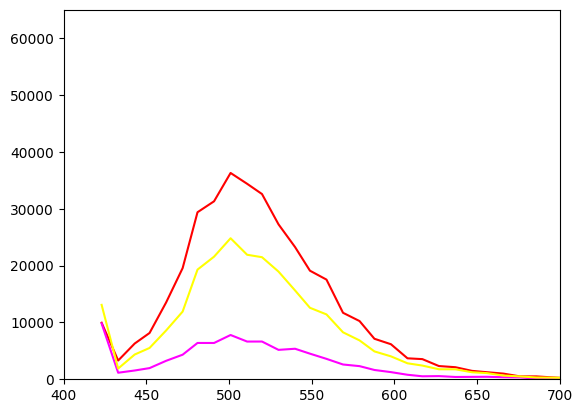

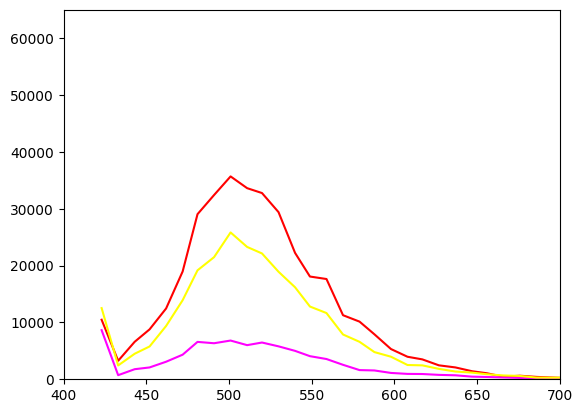

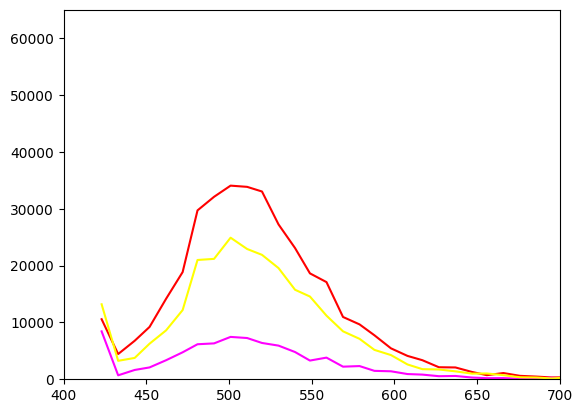

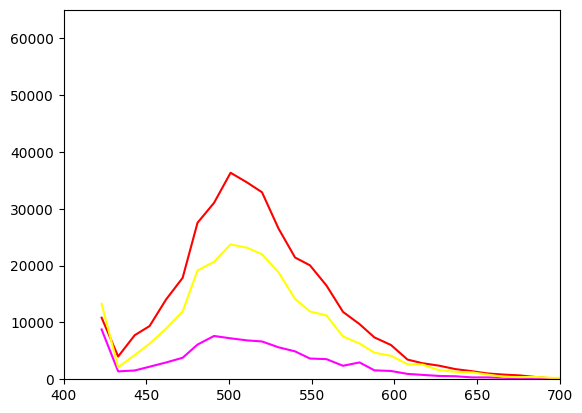

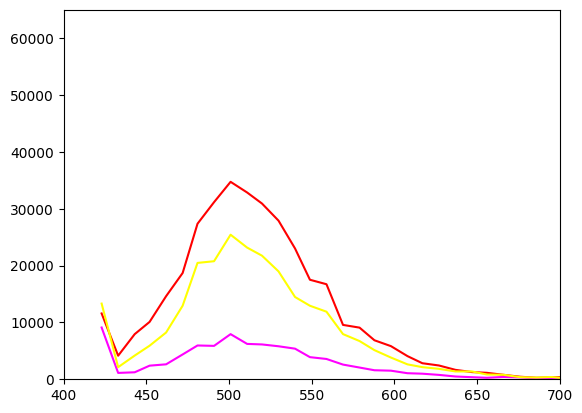

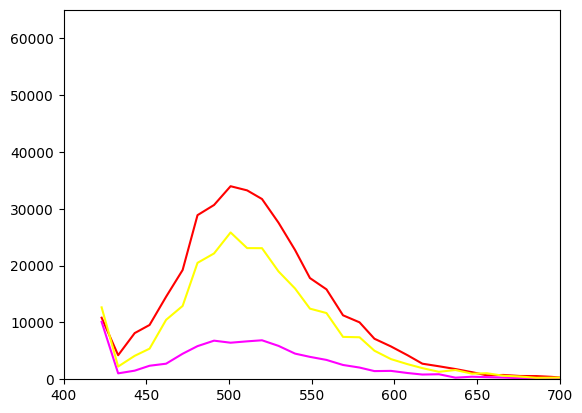

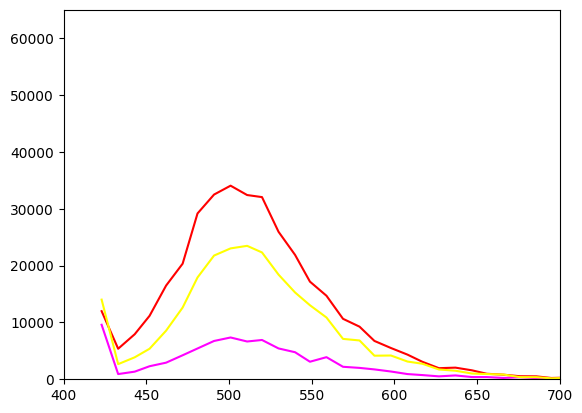

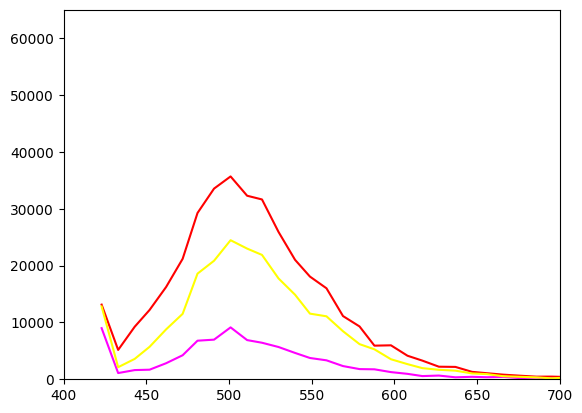

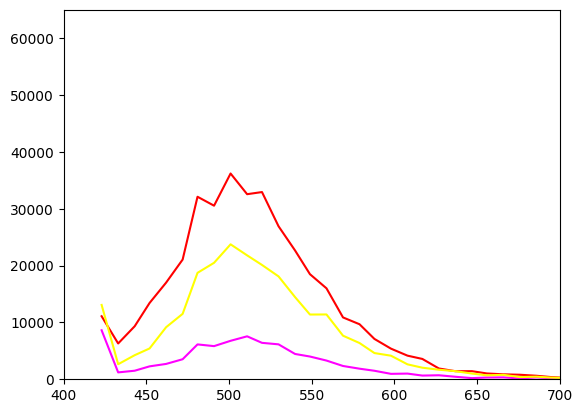

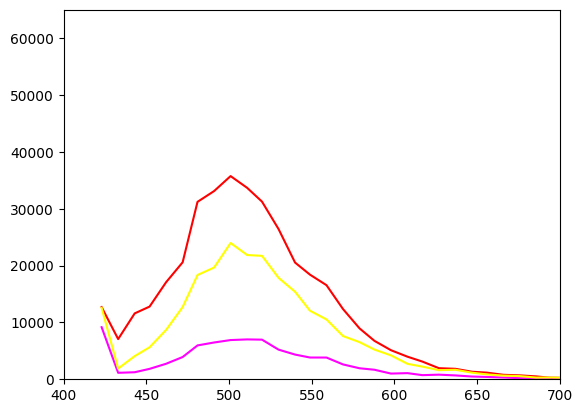

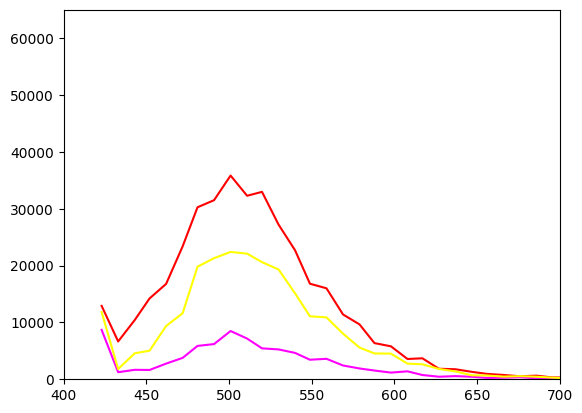

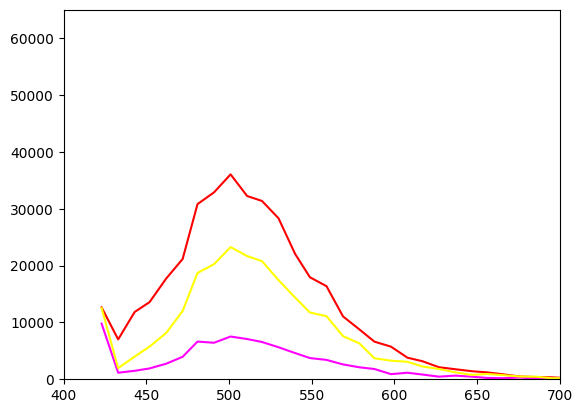

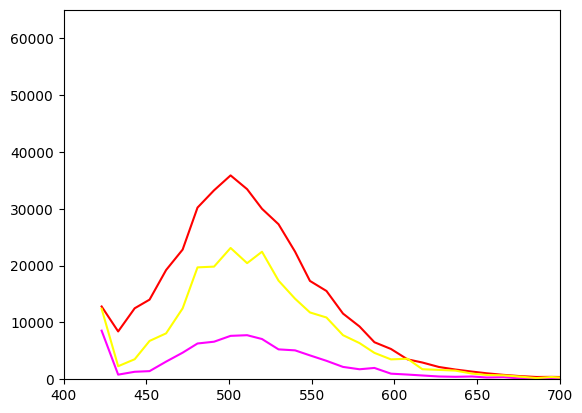

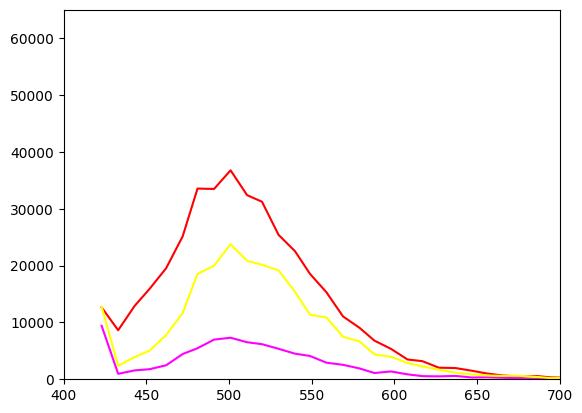

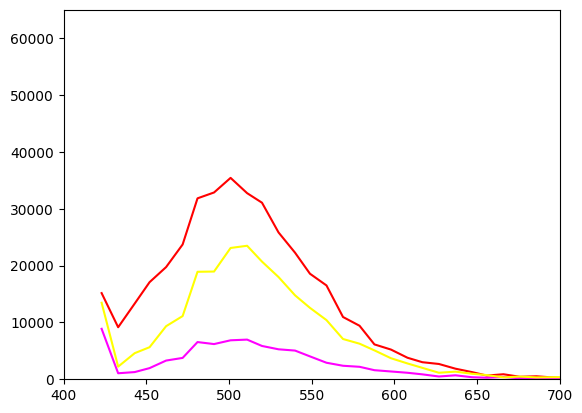

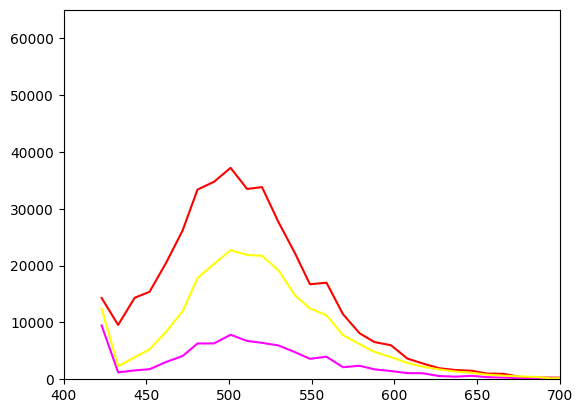

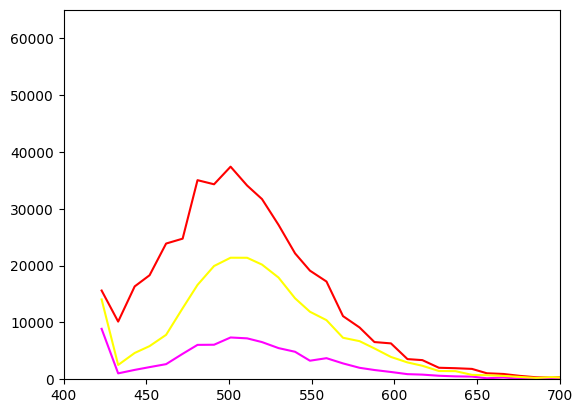

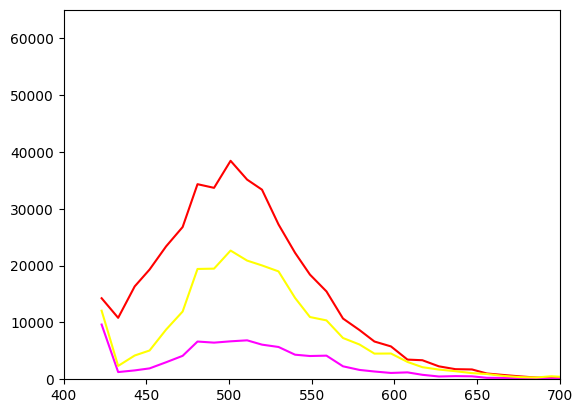

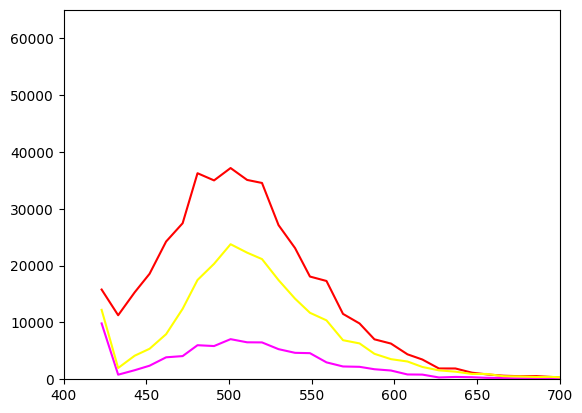

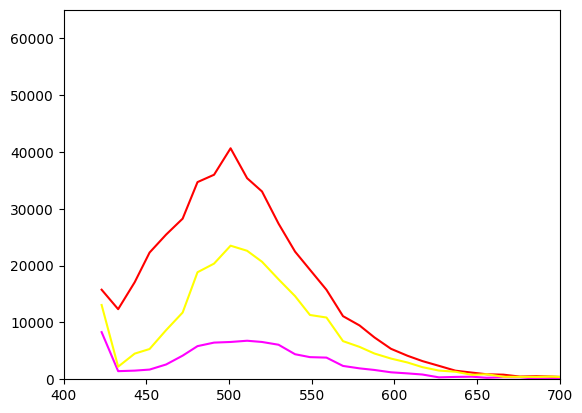

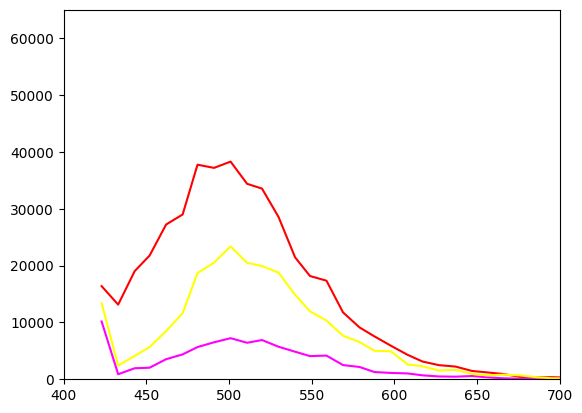

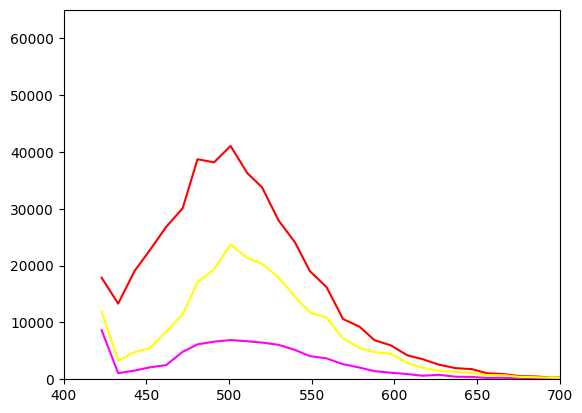

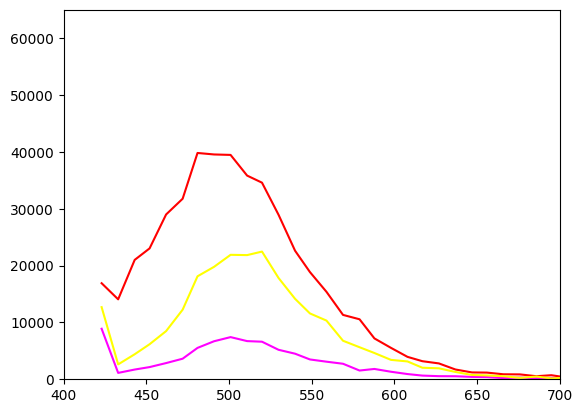

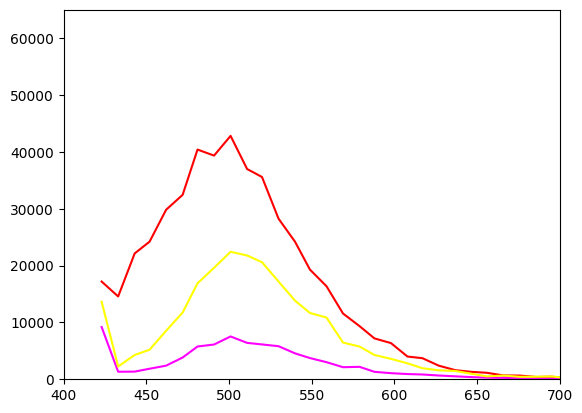

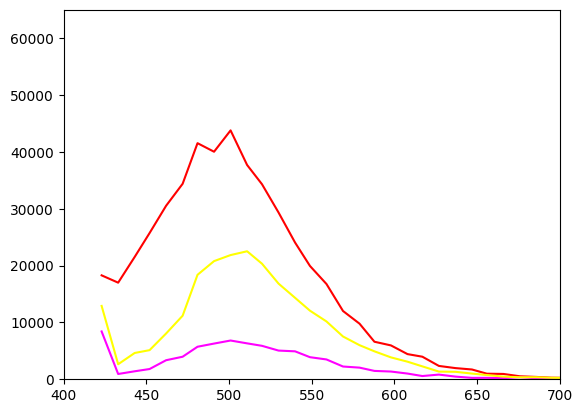

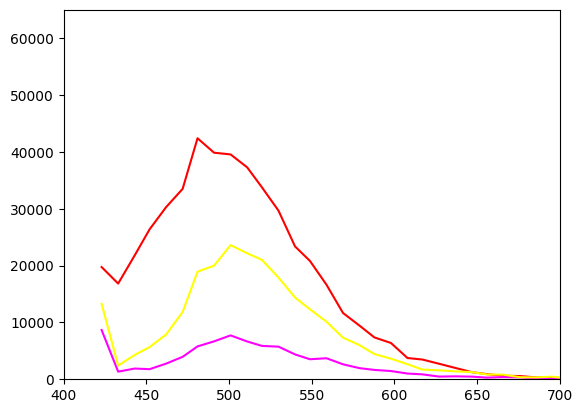

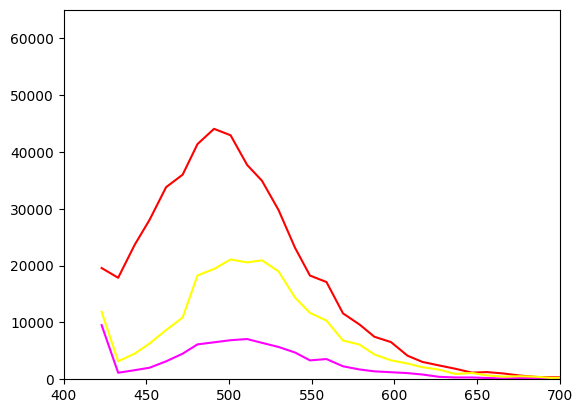

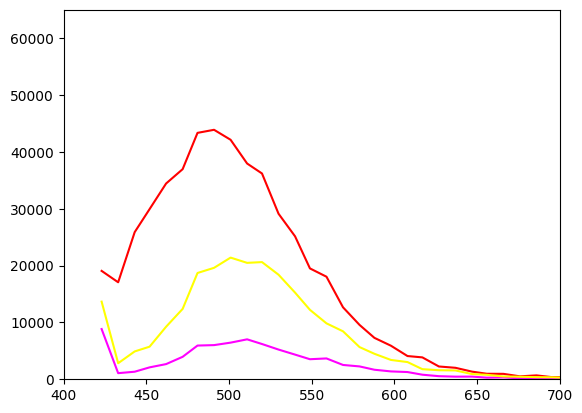

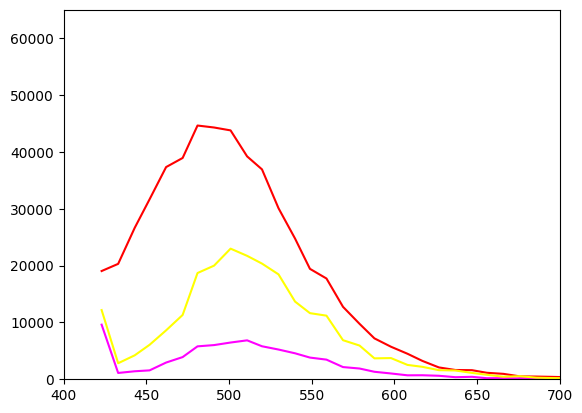

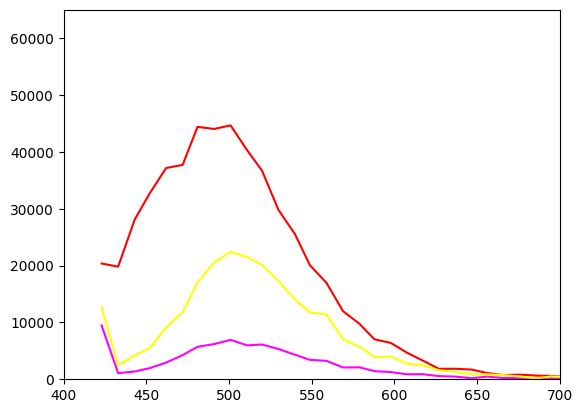

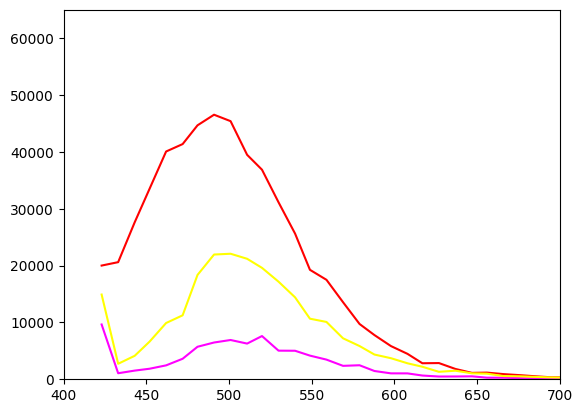

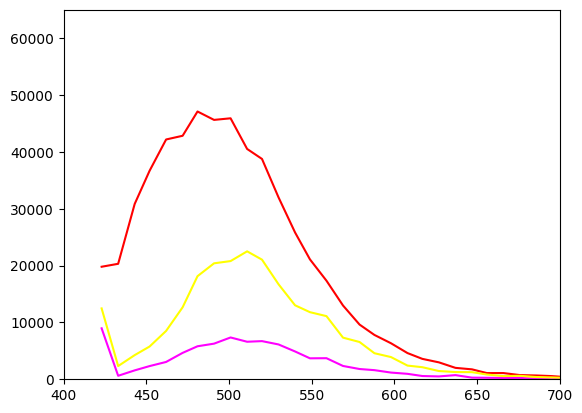

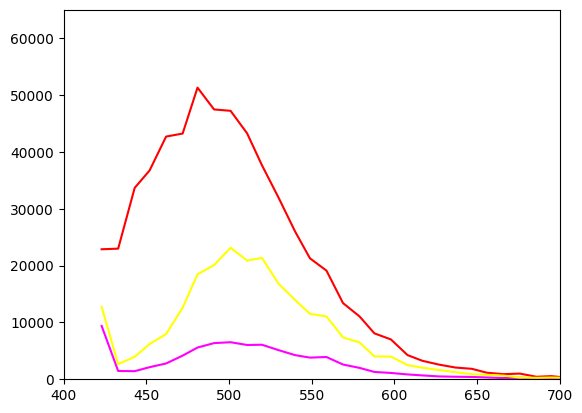

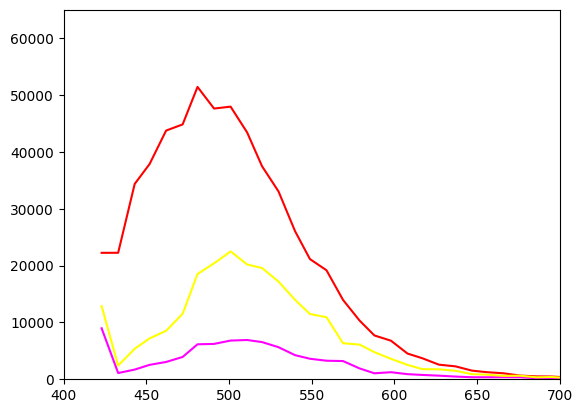

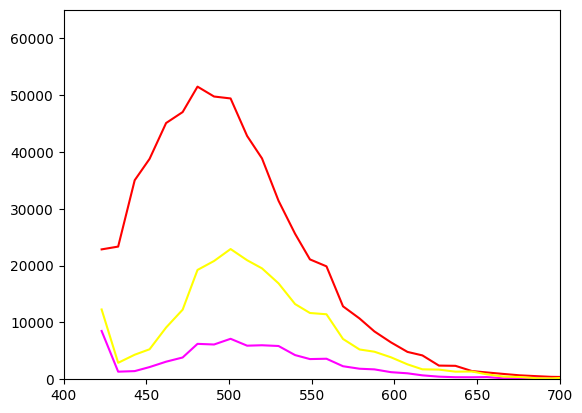

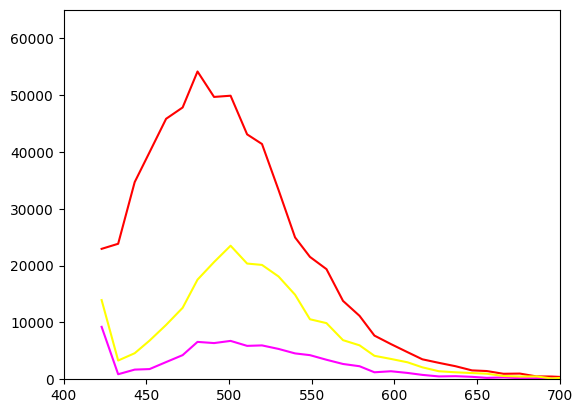

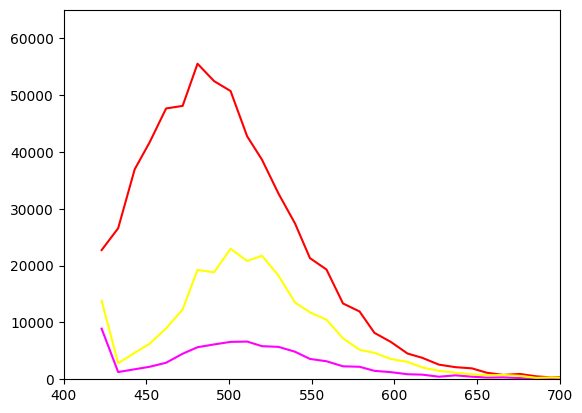

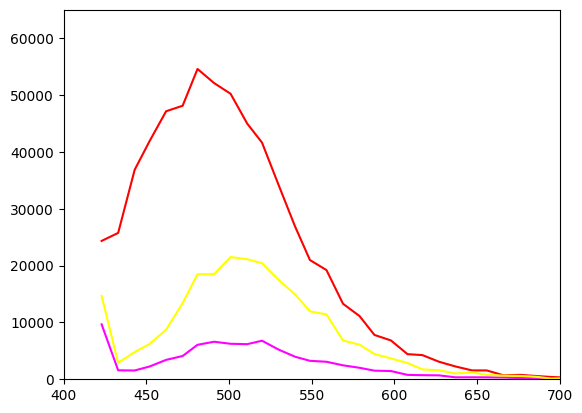

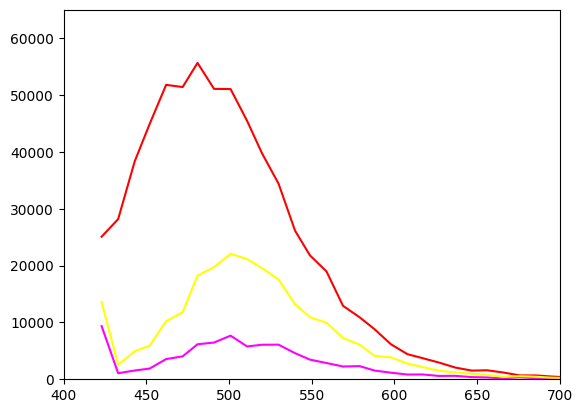

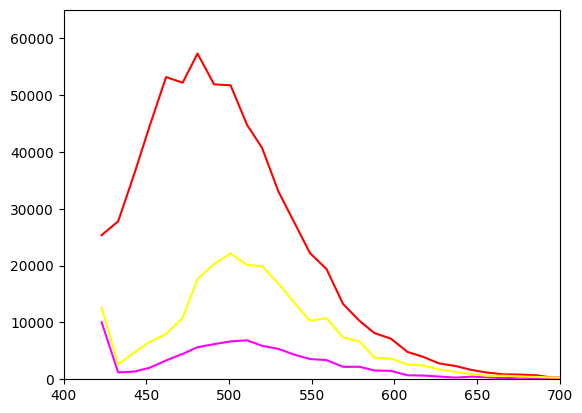

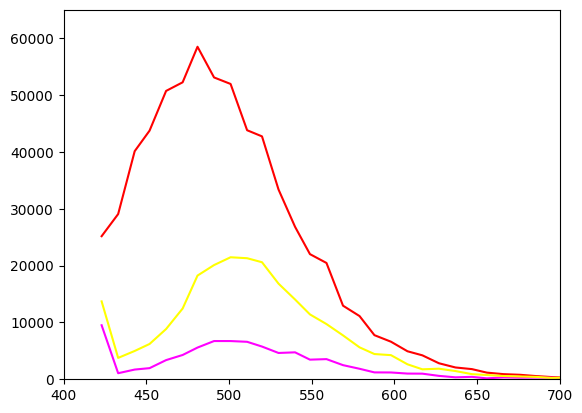

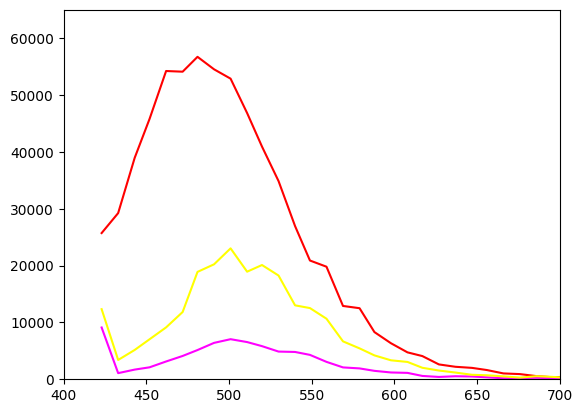

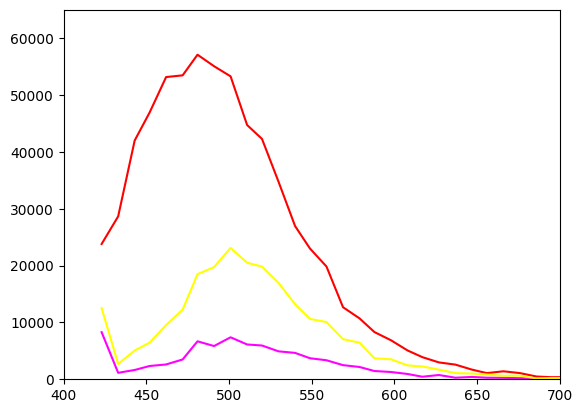

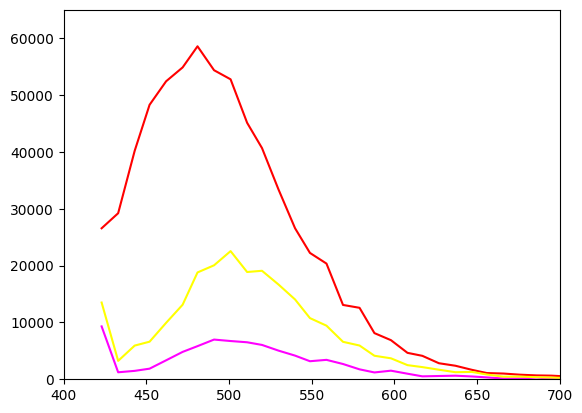

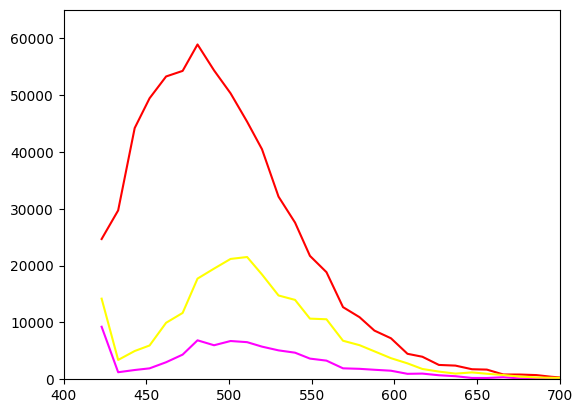

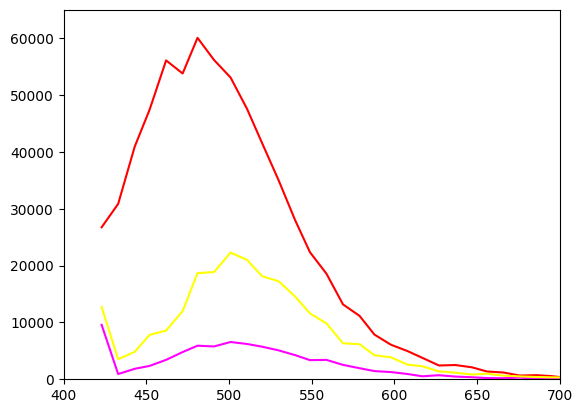

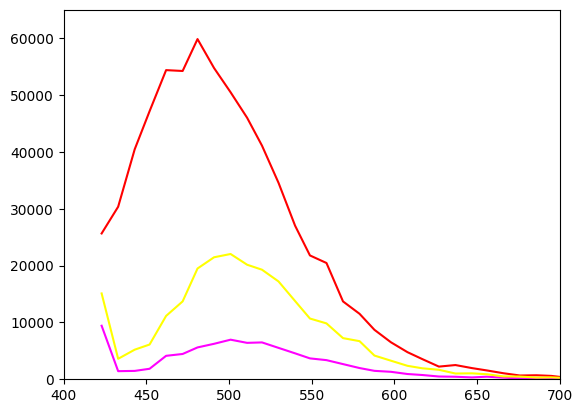

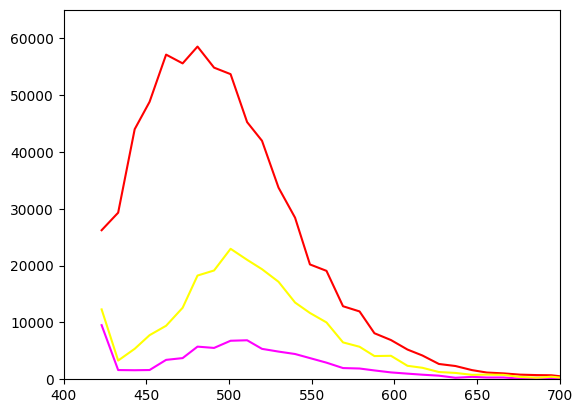

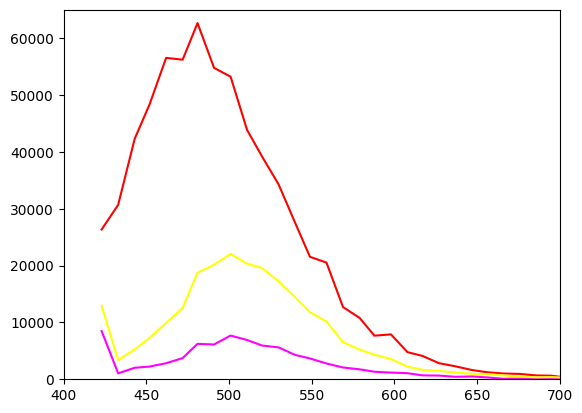

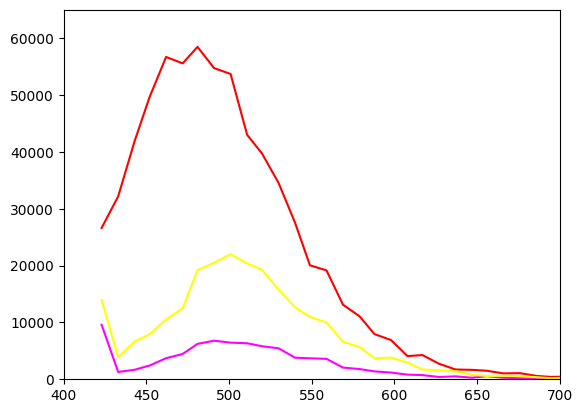

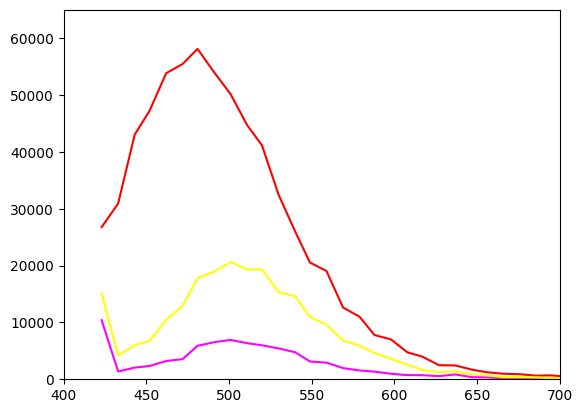

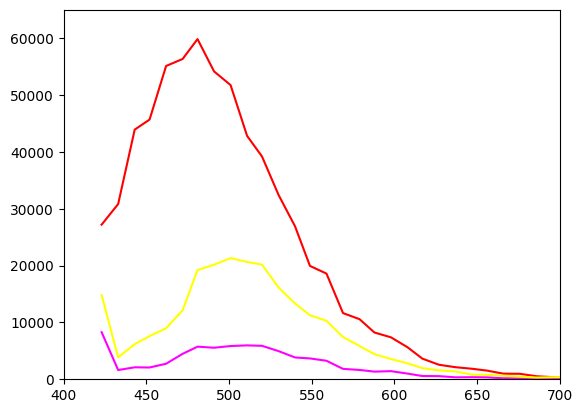

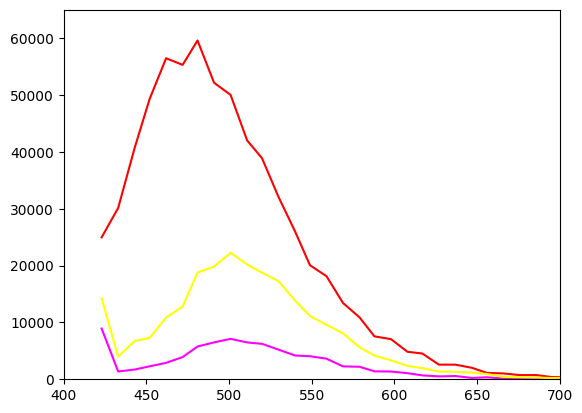

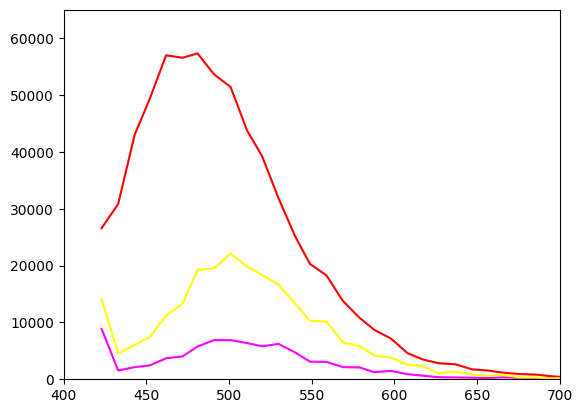

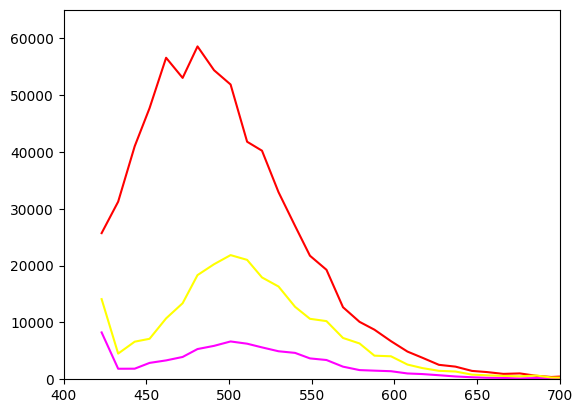

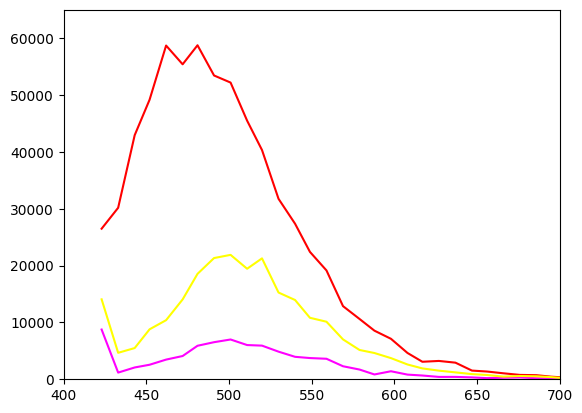

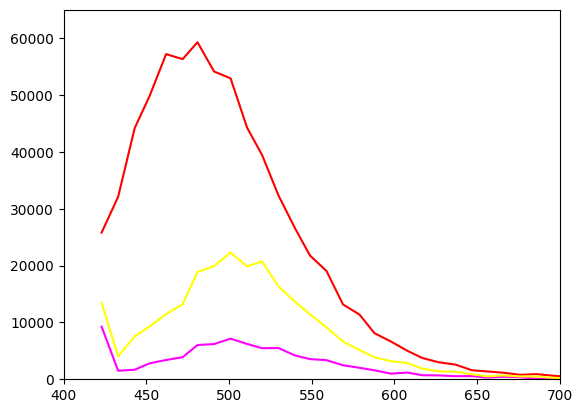

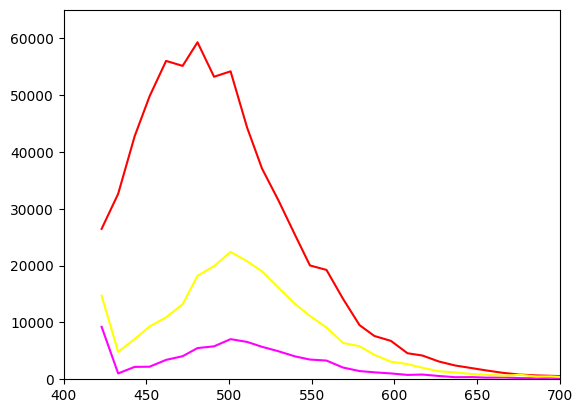

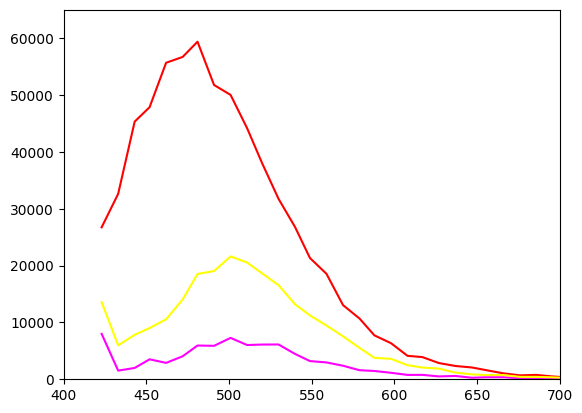

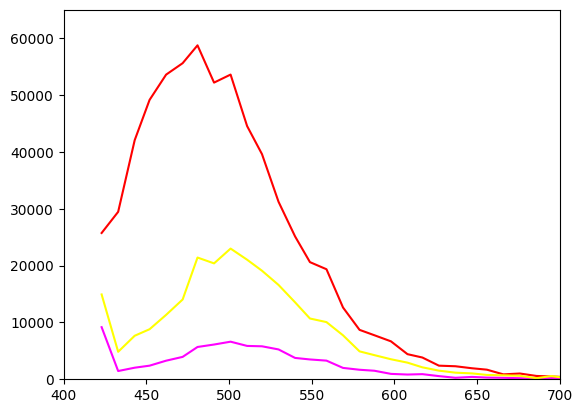

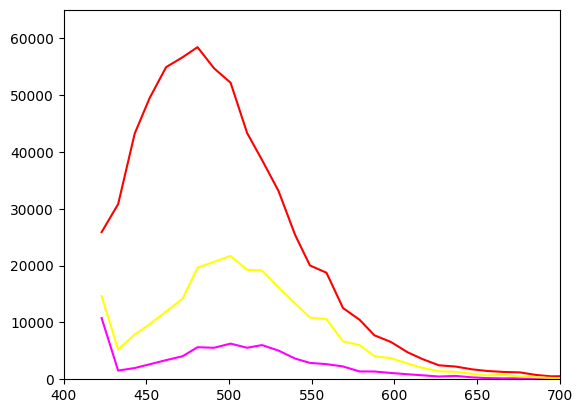

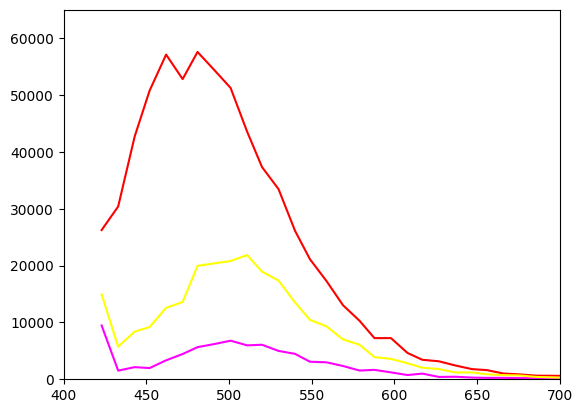

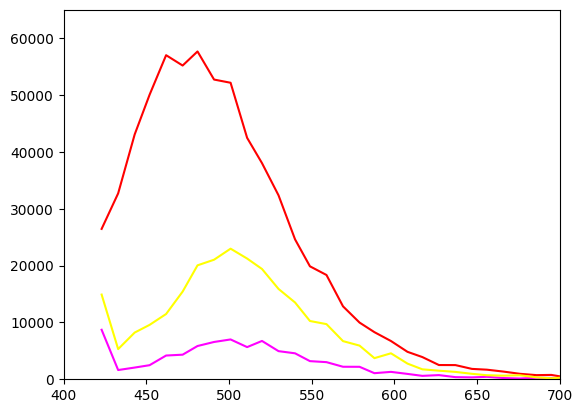

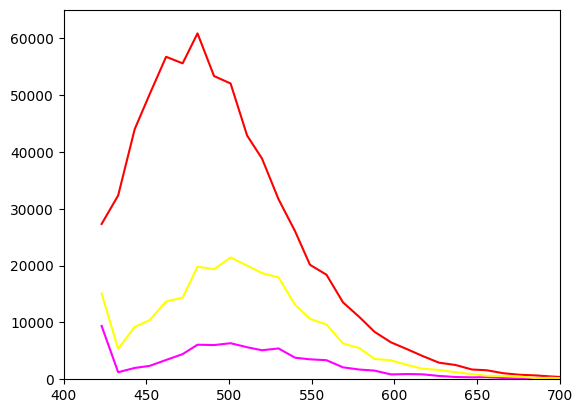

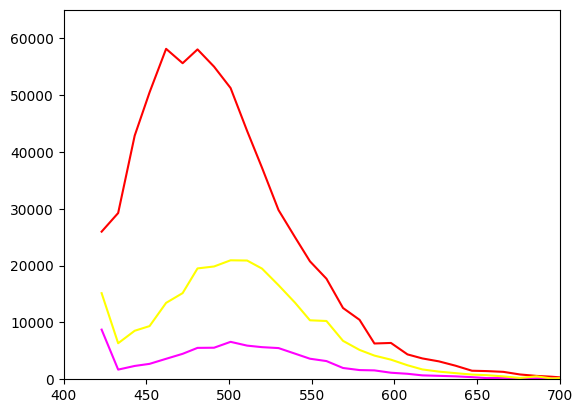

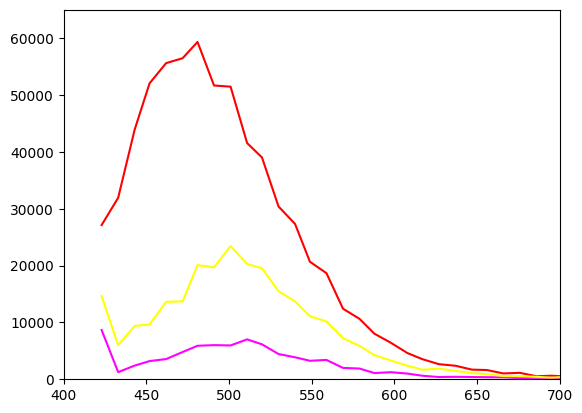

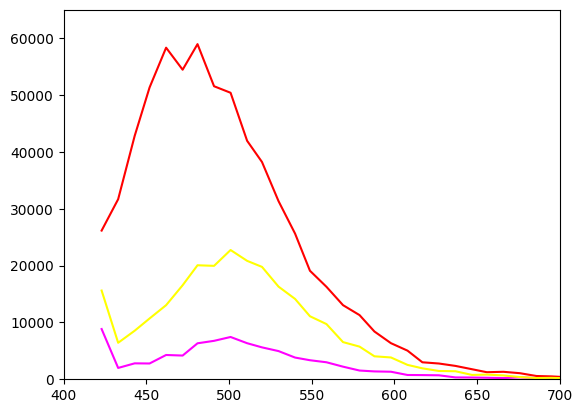

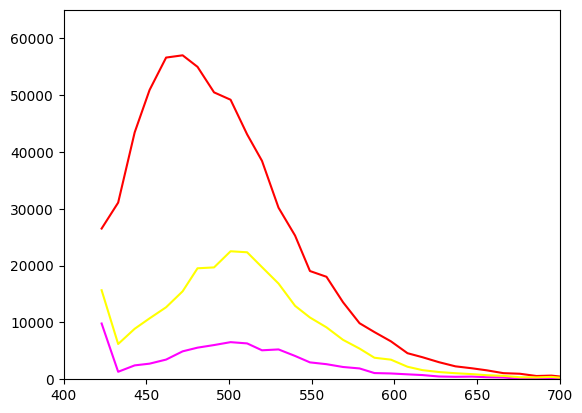

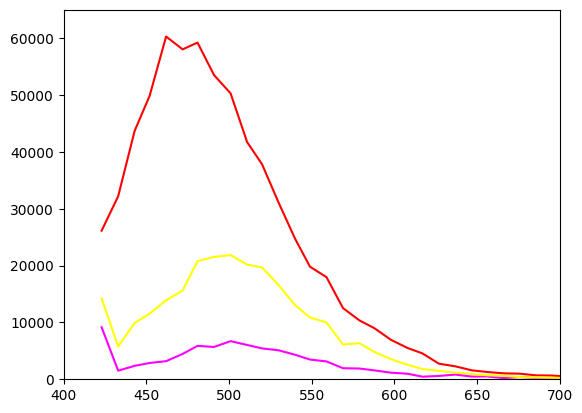

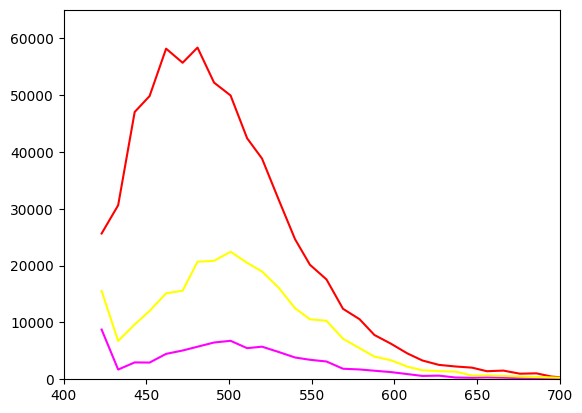

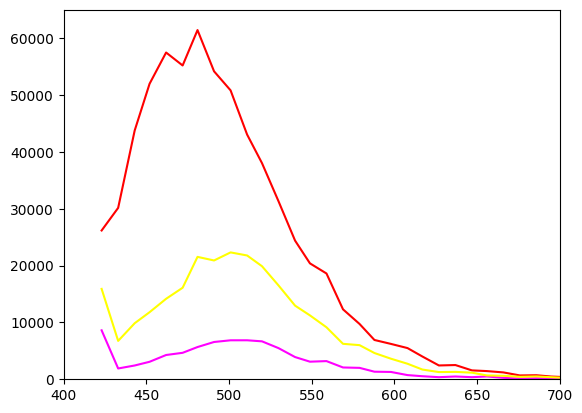

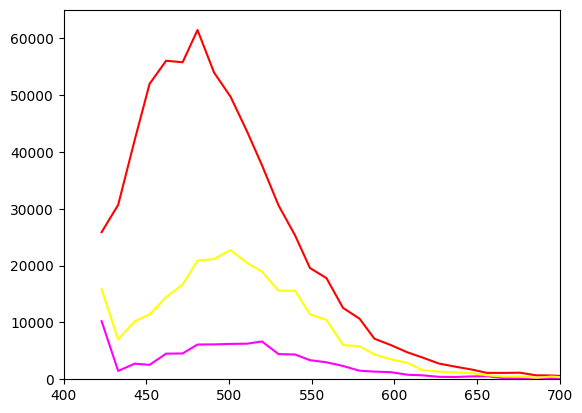

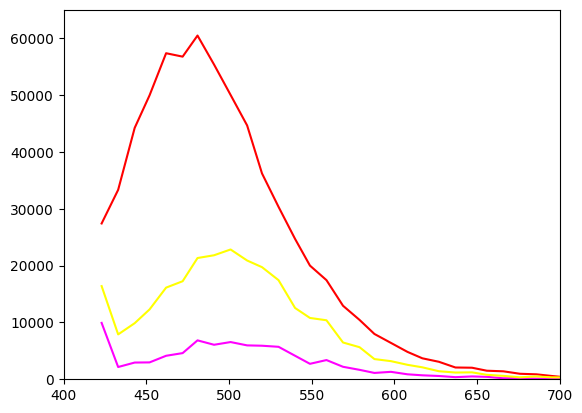

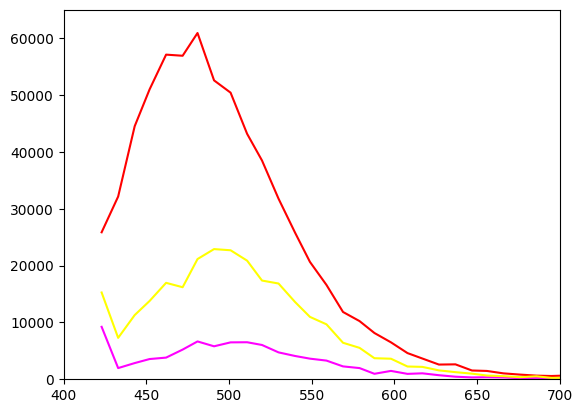

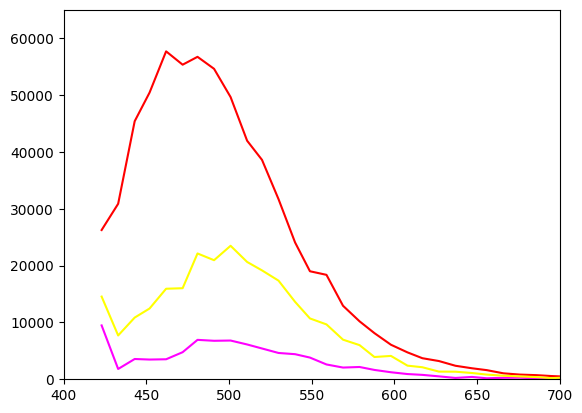

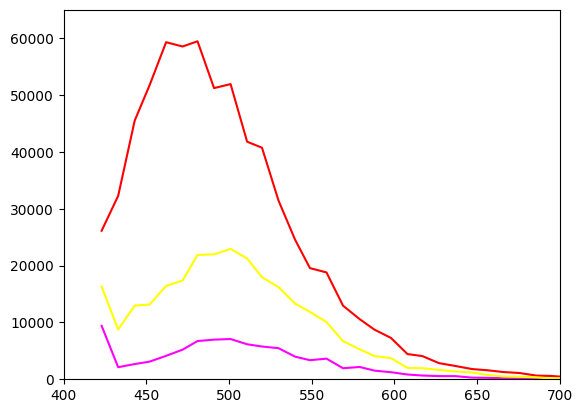

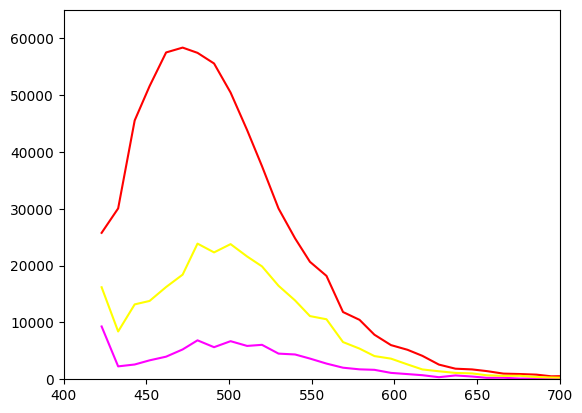

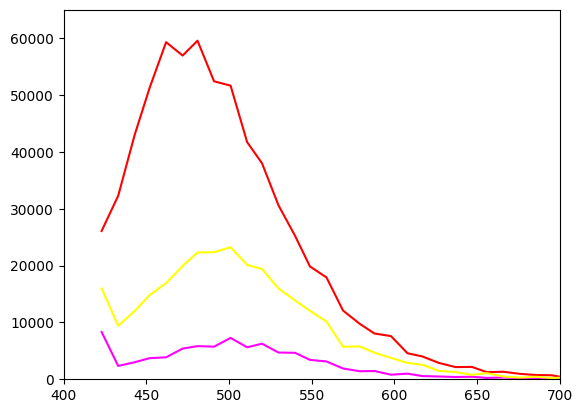

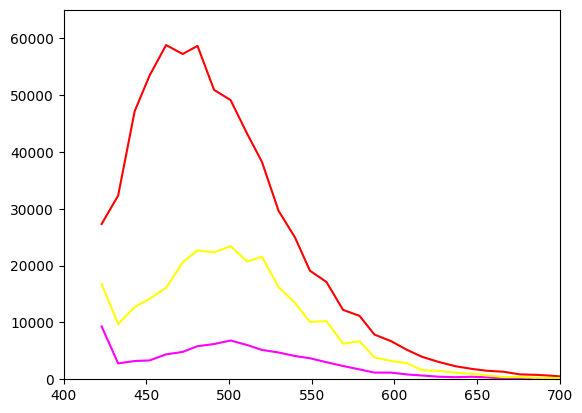

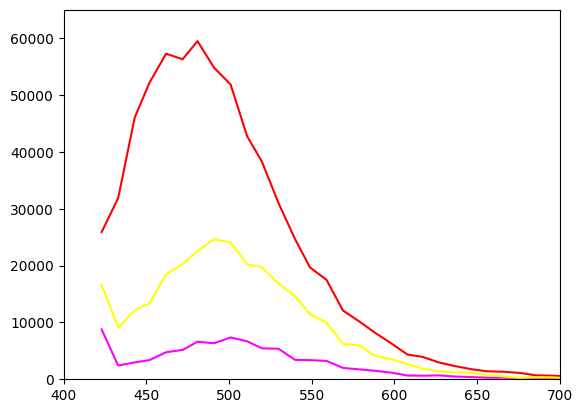

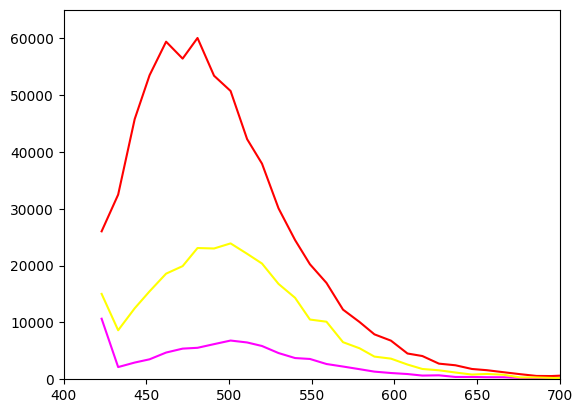

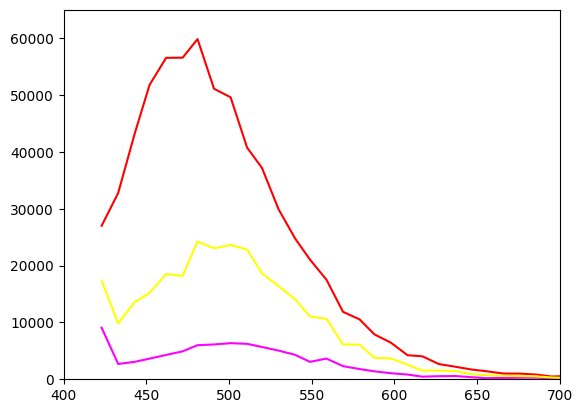

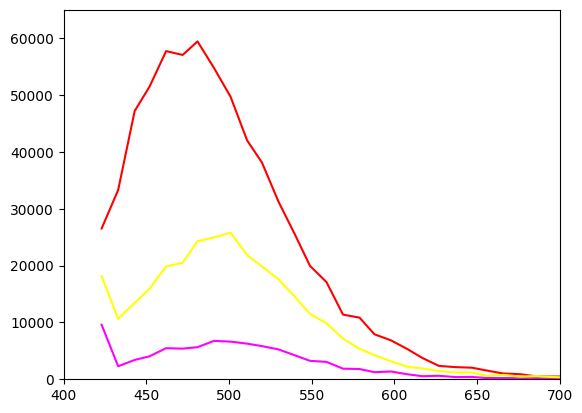

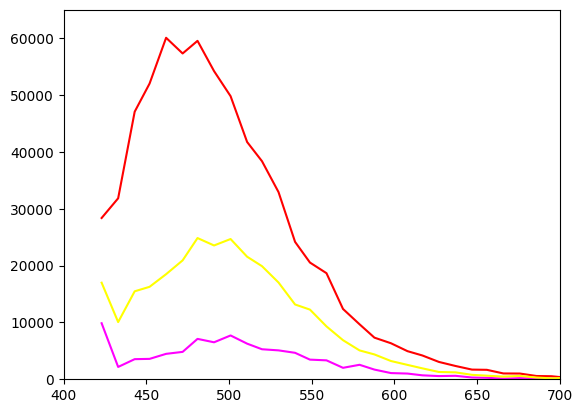

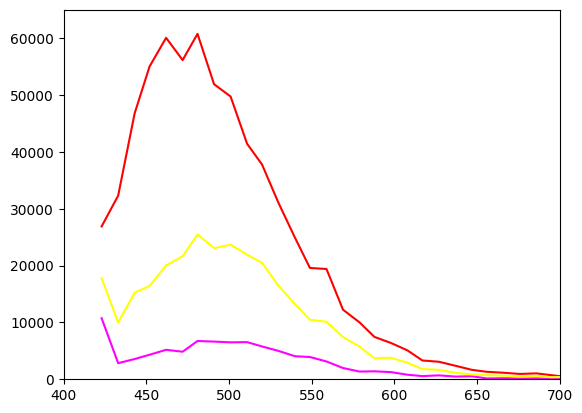

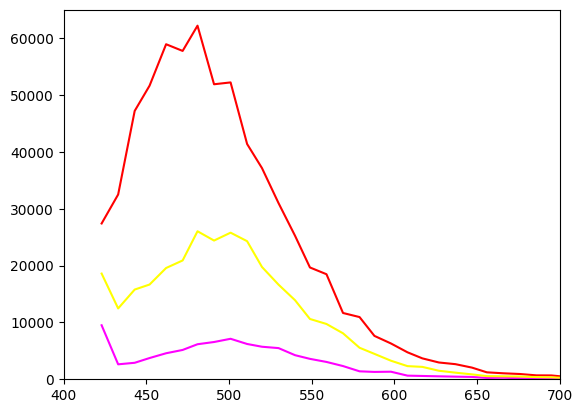

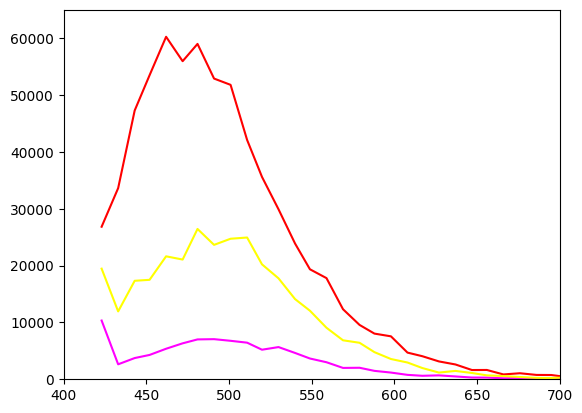

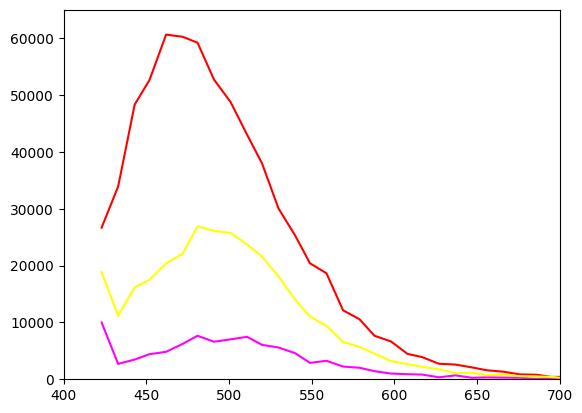

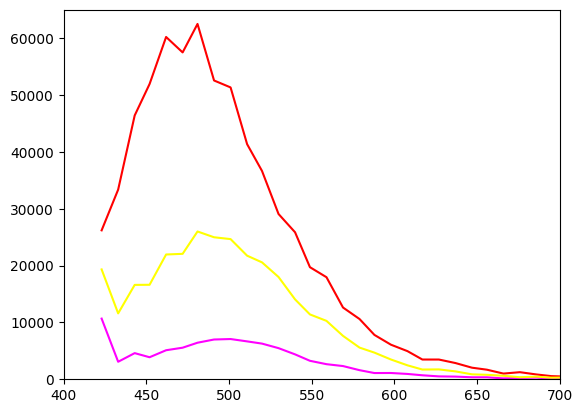

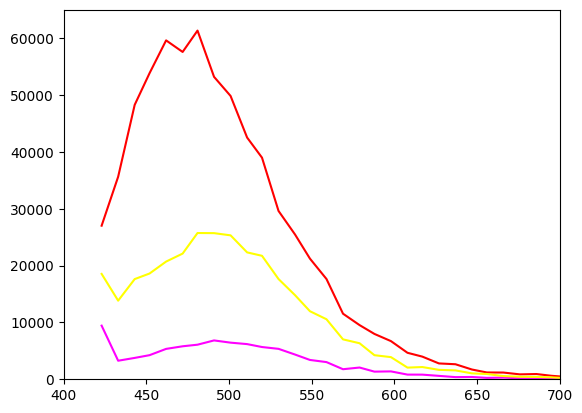

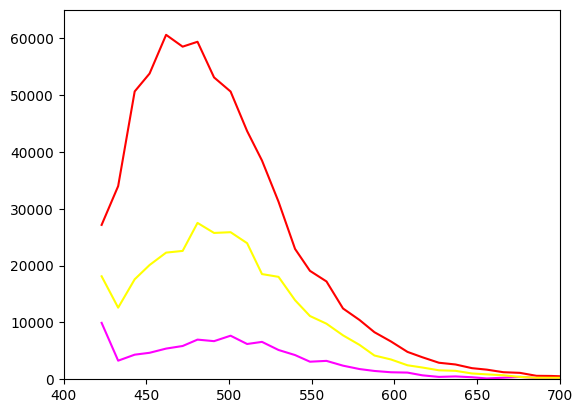

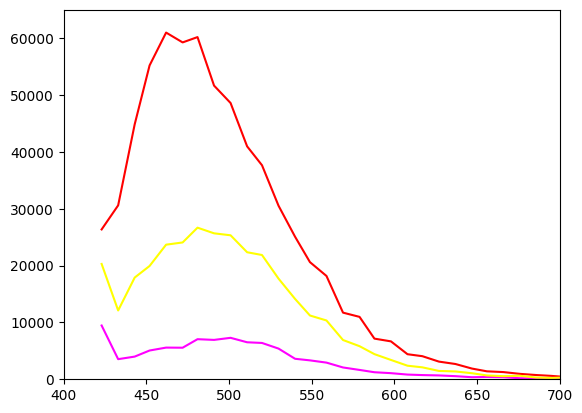

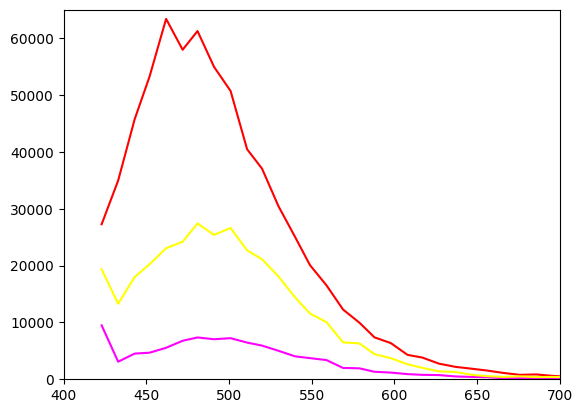

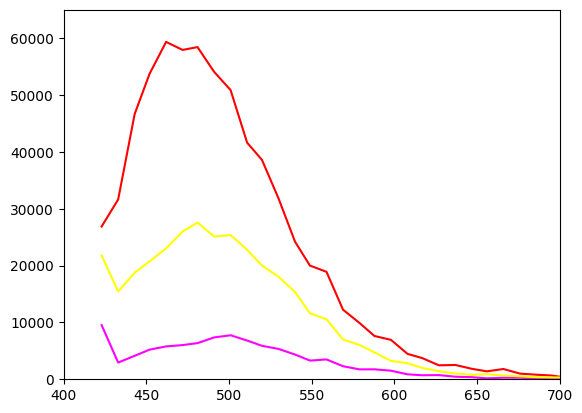

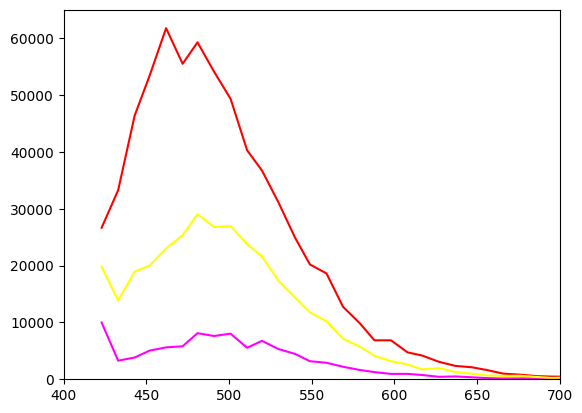

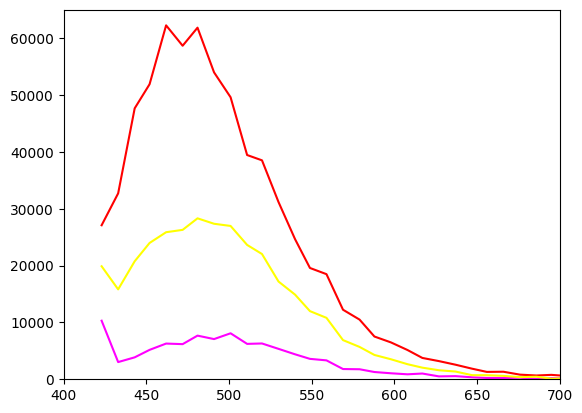

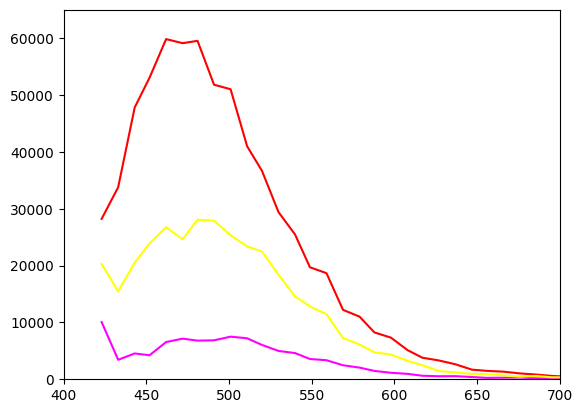

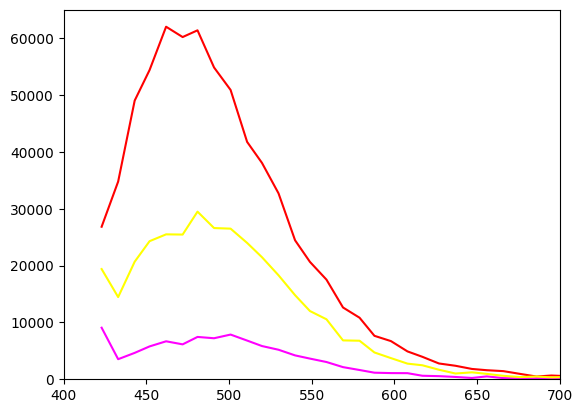

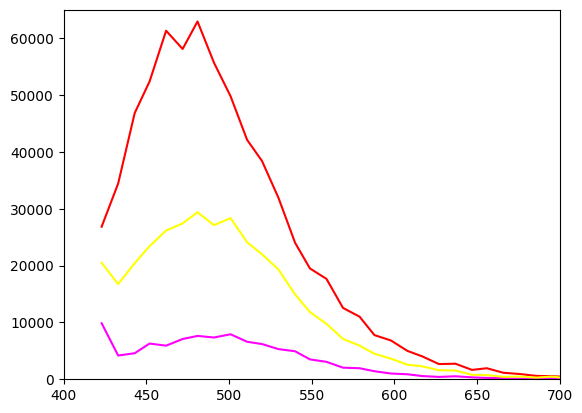

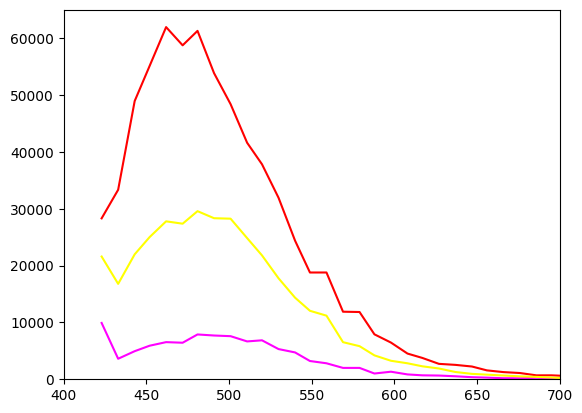

In [185]:
c = 100 #TEMPORARY

spectra_1 = np.zeros(shape=(32,c))
spectra_2 = np.zeros(shape=(32,c))
spectra_3 = np.zeros(shape=(32,c))

x_1,y_1,s_1 = 161, 254, 30
x_2,y_2,s_2 = 400, 100, 30
x_3,y_3,s_3 = 280, 350, 30

for i in range(c):
    image_i = image_raw[i,:,:,:]
    img = channels_to_lambda(image_i,wavelength_list)
    bc_corrected_image, alpha, beta = automatic_brightness_and_contrast(img)

    spectra_1[:,i] = spectra_extraction_ROI(x_1,y_1, s_1, image_i)
    spectra_2[:,i] = spectra_extraction_ROI(x_2,y_2, s_2, image_i)
    spectra_3[:,i] = spectra_extraction_ROI(x_3,y_3, s_3, image_i)
    

    # print(type(spectra_i))

    # print(spectra_i)

    output_image_file_name_corr = folder_path + '\\Animation_frames\\' + str(i) + '_corr' + '.png'
    output_image_file_name_mod = folder_path + '\\Modified_animation_frames\\' + str(i) + '_ROI' + '.png'
    
    output_plot_file_name = folder_path + '\\Plot_frames\\' + str(i) + '.png'

    # fig, ax = plt.subplots()
    # rect_1 = patches.Rectangle((x_1,y_1), s_1, s_1, linewidth=1, edgecolor='r', facecolor='none')
    # rect_2 = patches.Rectangle((x_2,y_2), s_2, s_2, linewidth=1, edgecolor='y', facecolor='none')
    # rect_3 = patches.Rectangle((x_3,y_3), s_3, s_3, linewidth=1, edgecolor='b', facecolor='none')

    # ax.add_patch(rect_1)
    # ax.add_patch(rect_2)
    # ax.add_patch(rect_3)

    image_ROI_1 = cv2.rectangle(bc_corrected_image, (x_1,y_1), (x_1+s_1,y_1+s_1), (0, 0, 255), 2)
    image_ROI_2 = cv2.rectangle(image_ROI_1, (x_2,y_2), (x_2+s_2,y_2+s_2), (255, 0, 255), 2)
    image_ROI_3 = cv2.rectangle(image_ROI_2, (x_3,y_3), (x_3+s_3,y_3+s_3), (0, 255, 255), 2)


    cv2.imwrite(output_image_file_name_corr, bc_corrected_image)
    cv2.imwrite(output_image_file_name_mod, image_ROI_3)
    # cv2.imwrite(output_image_file_name_mod, figure)

    fig, ax = plt.subplots( nrows=1, ncols=1 )
    ax.set_xlim([400, 700])
    ax.set_ylim([0, 65000])
    ax.plot(wavelength_list, spectra_1[:,i], color = 'red')
    ax.plot(wavelength_list, spectra_2[:,i], color = 'magenta')
    ax.plot(wavelength_list, spectra_3[:,i], color = 'yellow')
    # print(spectra[:,i])

    
    
    fig.savefig(output_plot_file_name)
    # plt.close()  #If we wont show each of the hundreds of plots

# print(spectra)

# spectra_df = pd.DataFrame(spectra)

# print(spectra_df)



In [ ]:
output_spectra_file_name = folder_path + 'spectra' + '.xlsx'

# spectra_df.to_excel(output_spectra_file_name, index=False)  

In [ ]:
fig = px.line(spectra_df, animation_frame=1)
fig.show()

In [ ]:
with tf.TiffFile(path) as tif:
       metadata = tif.pages[5].tags

print(metadata)